In [1]:
import jax
import jax.numpy as jnp

from jax import random
from jax import grad,value_and_grad
from jax.test_util import check_grads

# Jacobian vs Grad

Grad works on scalar functions, Jacobian works on vector functions.

In [2]:
# f(x) = x1^2 + x2^2
# paraboloid in 3D space
def paraboloid(x):
    return jnp.sum(x**2)

# gradf(x) = [2x1, 2x2]
# Our explicit gradient function
def g_paraboloid(x):
    return 2 * x 

# JAX's grad operator
grad_paraboloid = grad(paraboloid)

# three different input
input = jnp.array([[0.2, 0.3], [2.4, 3.6], [4.4, 2.1]])
for x in input:
    print("Explicit Gradient Function: ", g_paraboloid(x))
    print("JAX Gradient Function: ", grad_paraboloid(x))
    print("")

Explicit Gradient Function:  [0.4 0.6]
JAX Gradient Function:  [0.4 0.6]

Explicit Gradient Function:  [4.8 7.2]
JAX Gradient Function:  [4.8 7.2]

Explicit Gradient Function:  [8.8 4.2]
JAX Gradient Function:  [8.8 4.2]



In [3]:
jax.jacfwd(paraboloid)(input)

Array([[0.4, 0.6],
       [4.8, 7.2],
       [8.8, 4.2]], dtype=float32)

In [4]:
#Need to use the jax.jacfwd operator to compute the gradient of a vector valued function
#grad will throw an error
#vector valiued function
def f(x):
    return jnp.array([x[0]**2, x[1]**2])

#gradf(x) = [2x1, 2x2]
def g_f(x):
    return jnp.array([2*x[0], 2*x[1]])

#JAX's grad operator
grad_f = jax.jacfwd(f)

#three different input
input = jnp.array([0.2, 0.3])
print("Explicit Gradient Function: ", g_f(input))
print("JAX Gradient Function: ", grad_f(input))
print("")


Explicit Gradient Function:  [0.4 0.6]
JAX Gradient Function:  [[0.4 0. ]
 [0.  0.6]]



# Bilevel Optimizarion

We will optimize min_x F(x,y*)

with y* = argmin_y f(x,y)

The optimal solution is y* = x, which yeilds x,y = (1.5, 1.5)

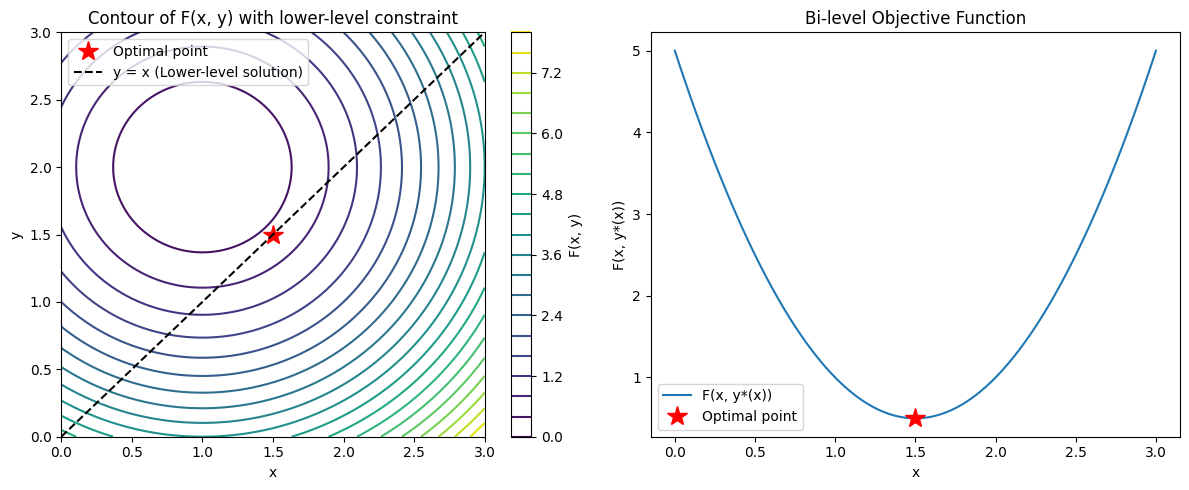

In [498]:
import numpy as np
import matplotlib.pyplot as plt

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (y - x)**2

# Lower-level solution
def y_star(x):
    return x  # The optimal y for any given x is always x

# Upper-level objective, accounting for the lower-level solution
def F_bilevel(x): #envelope theorem - just do GD on this
    return F(x, y_star(x))

# Correct analytical solution
x_opt, y_opt = 1.5, 1.5

# Plotting
x = np.linspace(0, 3, 100)
y = np.linspace(0, 3, 100)
X, Y = np.meshgrid(x, y)
Z = F(X, Y)
Z_g =f(X,Y)

# Bi-level objective
F_bi = F_bilevel(x)

plt.figure(figsize=(12, 5))

# Left plot: Contour of F(x,y) with y=x line
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=20)
plt.colorbar(label='F(x, y)')
plt.plot(x_opt, y_opt, 'r*', markersize=15, label='Optimal point')
plt.plot(x, x, 'k--', label='y = x (Lower-level solution)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour of F(x, y) with lower-level constraint')
plt.legend()

# Right plot: Bi-level objective F(x, y*(x))
plt.subplot(1, 2, 2)
plt.plot(x, F_bi, label='F(x, y*(x))')
plt.plot(x_opt, F_bilevel(x_opt), 'r*', markersize=15, label='Optimal point')
plt.xlabel('x')
plt.ylabel('F(x, y*(x))')
plt.title('Bi-level Objective Function')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
x = 3.
for _ in range(200):
    x = x - 0.01 * grad(F_bilevel)(x)
x, y_star(x)

(Array(1.5004267, dtype=float32, weak_type=True),
 Array(1.5004267, dtype=float32, weak_type=True))

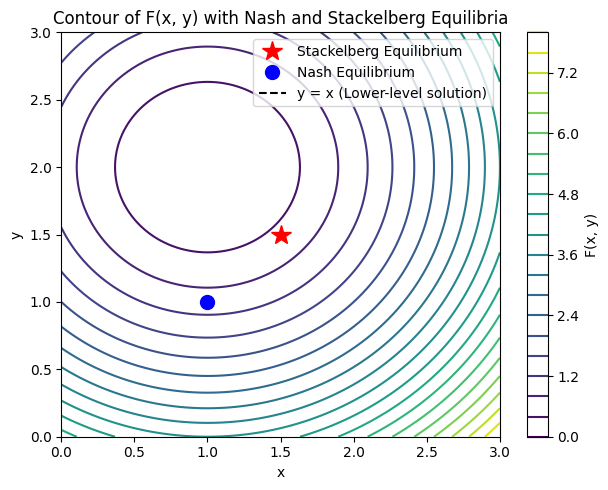

In [454]:
# Bi-level objective (Stackelberg)
F_bi = F_bilevel(x)

# Correct analytical solution for Stackelberg
x_opt_stackelberg, y_opt_stackelberg = 1.5, 1.5

# Nash Equilibrium solution
x_nash, y_nash = 1, 1

plt.figure(figsize=(12, 5))

# Left plot: Contour of F(x,y) with y=x line and Nash equilibrium
plt.subplot(1, 2, 1)
plt.contour(X, Y, Z, levels=20)
plt.colorbar(label='F(x, y)')
plt.plot(x_opt_stackelberg, y_opt_stackelberg, 'r*', markersize=15, label='Stackelberg Equilibrium')
plt.plot(x_nash, y_nash, 'bo', markersize=10, label='Nash Equilibrium')
plt.plot(x, x, 'k--', label='y = x (Lower-level solution)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour of F(x, y) with Nash and Stackelberg Equilibria')
plt.legend()


plt.tight_layout()
plt.show()

## Total derivative

I manually solve the derivative calulations to find compute the total derivative. Note that you do not have to nest. You compute the derivative for the y optimization, then the total for x

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (x - y)**2

def df_dy(x, y):
    return 2 * (y - x)

def d2f_dy2(x, y):
    return 2

def dF_dx(x, y):
    return 2 * (x - 1)

def dF_dy(x, y):
    return 2 * (y - 2)

def dy_dx(x):
    return 1

# Hyperparameters
learning_rate = 0.01
num_iterations = 500

# Initialize x
x = 0.0

In [9]:
def naive_gradient(x, y):
    #with access to the total derivative, we get
    x_history = [x]
    y_history = [y]
    
    for _ in range(num_iterations):
        for _ in range(10):
            y -= learning_rate * df_dy(x, y)
        y_history.append(y)
        implicit_grad = dF_dx(x, y)
        x -= learning_rate * implicit_grad
        x_history.append(x)
    
    return x_history, y_history  # y = x for all x

x_naive, y_naive = naive_gradient(0.1,0.1)

x_naive[-1], y_naive[-1]

(0.9999630784133691, 0.9999585461329162)

In [10]:
def total_gradient(x, y):
    #with access to the total derivative, we get
    x_history = [x]
    y_history = [y]
    
    for _ in range(num_iterations):
        y -= learning_rate * df_dy(x, y)
        y_history.append(y)
        implicit_grad = dF_dx(x, y) + dF_dy(x, y)*dy_dx(x)# Corrected this line
        x -= learning_rate * implicit_grad
        x_history.append(x)
    
    return x_history, y_history  # y = x for all x

x_total, y_total = total_gradient(0.1,0.1)



In [11]:
x_analytical = 1.5
y_analytical = 1.5

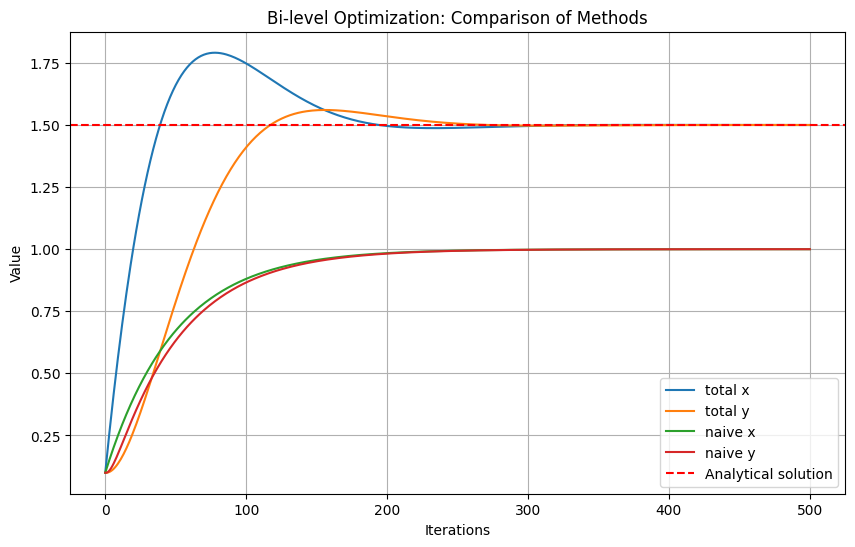

Final results:
Unrolled: x = 1.5000, y = 1.5001
Analytical: x = 1.5000, y = 1.5000


In [12]:
plt.figure(figsize=(10, 6))
plt.plot(x_total, label='total x')
plt.plot(y_total, label='total y')
plt.plot(x_naive, label='naive x')
plt.plot(y_naive, label='naive y')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Bi-level Optimization: Comparison of Methods')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final results:")
print(f"Unrolled: x = {x_total[-1]:.4f}, y = {y_total[-1]:.4f}")
print(f"Analytical: x = {x_analytical:.4f}, y = {y_analytical:.4f}")

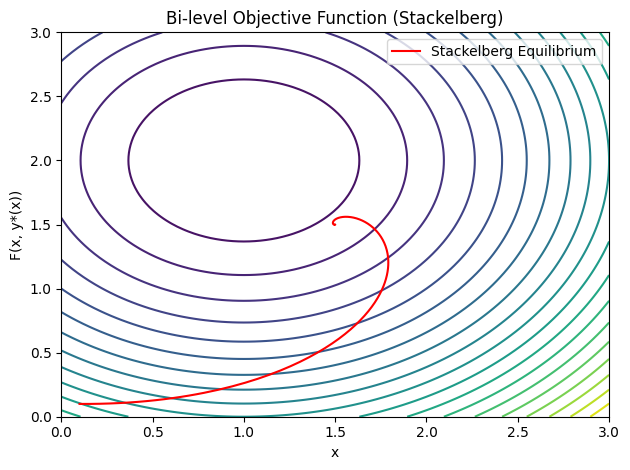

In [455]:
# Right plot: Bi-level objective F(x, y*(x)) for Stackelberg
plt.contour(X, Y, Z, levels=20)

plt.plot(x_total,y_total, 'r', markersize=15, label='Stackelberg Equilibrium')
plt.xlabel('x')
plt.ylabel('F(x, y*(x))')
plt.title('Bi-level Objective Function (Stackelberg)')
plt.legend()

plt.tight_layout()
plt.show()

In [469]:
z_total[-1]

Array(0.4999274, dtype=float32, weak_type=True)

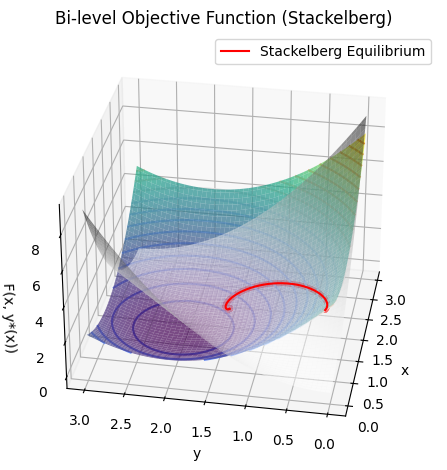

In [518]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming X, Y, Z, and F are already defined and contain your data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_total, y_total, z_total, color='red', s=10, alpha=1)  # Use scatter for larger markers

# Create the 3D surface plot
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax.plot_surface(X, Y, Z_g, cmap='Greys', alpha=0.5)

# Optionally, add the contour lines on the surface
ax.contour3D(X, Y, Z, levels=20, cmap='coolwarm')
#ax.contour3D(X, Y, Z_g, levels=20, cmap='coolwarm')

# Calculate z_total as F(x, y) for each (x, y) in x_total and y_total
z_total = [F(x, y) for x, y in zip(x_total, y_total)]

# Plot the Stackelberg Equilibrium points with proper z values
ax.plot(x_total, y_total, z_total, 'r-', label='Stackelberg Equilibrium', zorder=10)  # Use 'r-' for line or points connected
ax.view_init(elev=30, azim=190)  # Change these values to control the view

# Set labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('F(x, y*(x))')
ax.set_title('Bi-level Objective Function (Stackelberg)')
ax.legend()

plt.tight_layout()
plt.show()



In [14]:
#learn y_star(x) dynamically using envelope theorem

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (y - x)**2  # Lower-level objective

def learn_y_star(x, y_init=0.1, num_y_iterations=20, learning_rate_y=0.1):
    y = y_init
    for _ in range(num_y_iterations):
        y -= learning_rate_y * df_dy(x, y)  # Gradient descent on the lower-level objective f(x, y)
    return y

# Upper-level objective using learned y_star(x)
def F_bilevel(x):
    y_star = learn_y_star(x)  # Learn y_star dynamically
    return F(x, y_star)  # Plug y_star into F

def optimize_x(num_iterations, learning_rate_x):
    x = 0.1  # Initial value of x
    x_history = [x]
    
    for _ in range(num_iterations):
        # Compute the gradient of the upper-level objective
        grad_x = grad(F_bilevel)(x)  # Gradient with respect to x, which includes y_star(x)
        
        # Update x using gradient descent
        x -= learning_rate_x * grad_x
        x_history.append(x)
    
    return x_history

# Run the optimization
x_history = optimize_x(num_iterations=100, learning_rate_x=0.05)
x_history[-1], learn_y_star(x_history[-1])  # y_star at the optimal x


(Array(1.5051539, dtype=float32, weak_type=True),
 Array(1.4889536, dtype=float32, weak_type=True))

In [492]:
EPS = 0.001

@jax.jit
def F(x, y):
    return (x - 1)**2 + (y - 2)**2

@jax.jit
def g(x, y):
    return (y - x)**2  # Lower-level objective

@jax.jit
def lagrange(x, y, y_prime, λ):
    return F(x, y) + λ * (g(x, y) - g(x, y_prime))

@jax.jit
def h(x, y, y_prime):
    return g(x, y) - g(x, y_prime)




grad_lagrange = jax.jit(grad(lagrange, argnums=(0, 1, 2, 3)))
grad_g = jax.jit(grad(g, argnums=(0, 1)))

def optimize_x(num_iterations, lr, λ=20.0):
    x = 2. # Initial value of x
    y = 2.  # Initial value of y
    y_prime = 1.  # Initial value of y_prime
    h_val = h(x,y,y_prime)
    x_history, y_history, y_prime_history, λ_history, h_history = [x], [y], [y_prime], [λ], [h_val]
    h_history = [h_val]
    
    for i in range(num_iterations):
        #grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

        grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

            # Update y_prime using gradient ascent
        y_prime += lr * grad_y_prime

            #y_prime -= lr * grad_g(x,y_prime)[1]

        # Update λ using gradient ascent
        #grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

        λ += 100*lr * grad_λ


        h_val = h(x, y, y_prime)
        #λ += ((1)*h_val - h_history[-1])
        λ = max(0.0, λ)  # Project λ to be non-negative
        λ_history.append(λ)
        h_history.append(h_val)

      


        
        λ = min(max(0.0, λ),100.)  # Project λ to be non-negative

        # Compute the gradient of the Lagrangian
        #grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

        # Update x using gradient descent
        x -= lr * grad_x

        # Update y using gradient descent
        y -= lr * grad_y
        #y -= learning_rate_x * grad_y
                
        y_prime_history.append(y_prime)

        grad_norm = jnp.sqrt(grad_x**2 + grad_y**2 + grad_y_prime**2 + grad_λ**2)
        
        # Check KKT conditions
        if grad_norm < EPS and jnp.abs(h_val) < EPS:
            print(f"Converged at iteration {i}")
            break
        y_history.append(y)
        x_history.append(x)




    
    return x_history, y_history, y_prime_history, λ_history


lr = 0.01
# Run the optimization
x_history, y_history, y_prime_history, λ_history  = optimize_x(num_iterations=10000, lr=lr)
x_history[-1], y_history[-1]  # Optimal x

Converged at iteration 221


(Array(1.4861212, dtype=float32, weak_type=True),
 Array(1.5140679, dtype=float32, weak_type=True))

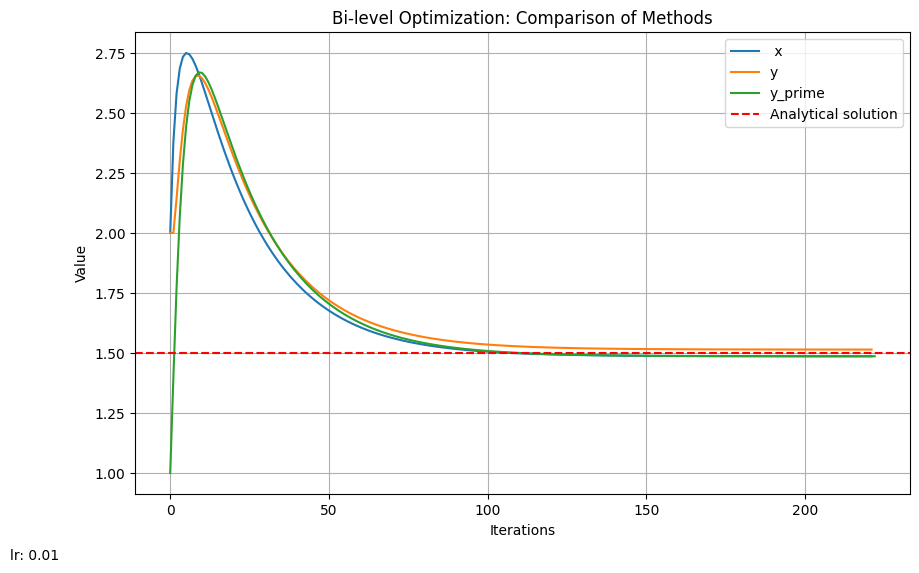

Final results:
Unrolled: x = 1.5000, y = 1.5001
Analytical: x = 1.5000, y = 1.5000


In [493]:
plt.figure(figsize=(10, 6))
plt.plot(x_history, label=' x')
plt.plot(y_history, label='y')
plt.plot(y_prime_history, label='y_prime')
#plt.plot(λ_history, label='λ')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Bi-level Optimization: Comparison of Methods')
plt.legend()
plt.grid(True)
plt.figtext(0., 0., 'lr: {:.2f}'.format(lr))
plt.savefig('figs/GDA.png')
plt.show()

print(f"Final results:")
print(f"Unrolled: x = {x_total[-1]:.4f}, y = {y_total[-1]:.4f}")
print(f"Analytical: x = {x_analytical:.4f}, y = {y_analytical:.4f}")

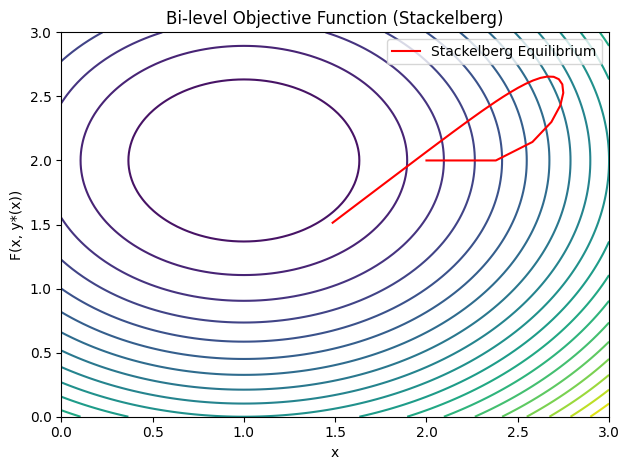

In [494]:
# Right plot: Bi-level objective F(x, y*(x)) for Stackelberg
plt.contour(X, Y, Z, levels=20)

plt.plot(x_history,y_history, 'r', markersize=15, label='Stackelberg Equilibrium')
plt.xlabel('x')
plt.ylabel('F(x, y*(x))')
plt.title('Bi-level Objective Function (Stackelberg)')
plt.legend()

plt.tight_layout()
plt.show()

In [392]:
@jax.jit
def F(x, y):
    return (x - 1)**2 + (y - 2)**2

@jax.jit
def g(x, y):
    return (y - x)**2  # Lower-level objective

@jax.jit
def lagrange(x, y, y_prime, λ):
    return F(x, y) + λ * (g(x, y) - g(x, y_prime))

@jax.jit
def h(x, y, y_prime):
    return g(x, y) - g(x, y_prime)




grad_lagrange = jax.jit(grad(lagrange, argnums=(0, 1, 2, 3)))
grad_F = jax.jit(grad(F, argnums=(0, 1)))
grad_g = jax.jit(grad(g, argnums=(0, 1)))
grad_h = jax.jit(grad(h, argnums=(0, 1, 2)))

def optimize_x(num_iterations, lr, λ=0.):
    x = 3. # Initial value of x
    y = 3.  # Initial value of y
    y_prime = 0.1  # Initial value of y_prime
    x_history, y_history, y_prime_history, λ_history = [x], [y], [y_prime], [λ]
    h_val = h(x, y, y_prime)
    h_history = [h_val]

    x_step_history, y_step_history = [0], [0]

    
    for _ in range(num_iterations):
        #_, grad_y_regret, grad_y_prime_regret = grad_regret(x, y, y_prime)

        # Compute the gradient of the Lagrangian

        for _ in range(10):
            # Update y_prime using gradient ascent
            y_prime -= lr* grad_g(x, y_prime)[1]

        h_val = h(x, y, y_prime)
        λ += ((1+lr)*h_val - lr*h_history[-1])
        λ = max(0.0, λ)  # Project λ to be non-negative
        λ_history.append(λ)
        h_history.append(h_val)

        
        # Update x using gradient descent
        nabla_Fx, nabla_Fy = grad_F(x,y)
        nabla_gx, nabla_gy = grad_g(x,y)
        nabla_bargx, _ = grad_g(x,y_prime)

        # print(x, y, nabla_Fx, nabla_Fy, λ)
        # print(nabla_gx, nabla_gy,nabla_bargx)

        x_step = lr*(nabla_Fx + λ*(nabla_gx - nabla_bargx))
        y_step = lr*(nabla_Fy + λ*(nabla_gy))


        x -= x_step
        y -= y_step
        x_step_history.append(x_step)
        y_step_history.append(y_step)

        x_history.append(x)
        y_history.append(y)
        y_prime_history.append(y_prime)




    
    return x_history, y_history, y_prime_history, λ_history, x_step_history, y_step_history

lr = 0.001
# Run the optimization
x_history, y_history, y_prime_history, λ_history, x_step_history, y_step_history  = optimize_x(num_iterations=10000, lr=lr)
x_history[-1], y_history[-1]  # Optimal x

(Array(1.4876567, dtype=float32, weak_type=True),
 Array(1.5129169, dtype=float32, weak_type=True))

In [393]:
x, y, y_prime = (1.5, 1.5, 1.1)

Fx, Fy = grad_F(x,y)
gx, gy = grad_g(x,y)
gprime_x, gprime_y = grad_g(x, y_prime)



Fx + 20*(gx - gprime_x), Fy + 20*gy

(Array(-14.999999, dtype=float32, weak_type=True),
 Array(-1., dtype=float32, weak_type=True))

In [394]:
x - (Fx + 20*(gx - gprime_x)), y - (Fy +20*gy)

(Array(16.5, dtype=float32, weak_type=True),
 Array(2.5, dtype=float32, weak_type=True))

In [395]:
grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(1.5, 1.5, 1.5, 1000.)
grad_x, grad_y, grad_y_prime, grad_λ

(Array(1., dtype=float32, weak_type=True),
 Array(-1., dtype=float32, weak_type=True),
 Array(-0., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))

In [396]:
x - grad_x, y - grad_y

(Array(0.5, dtype=float32, weak_type=True),
 Array(2.5, dtype=float32, weak_type=True))

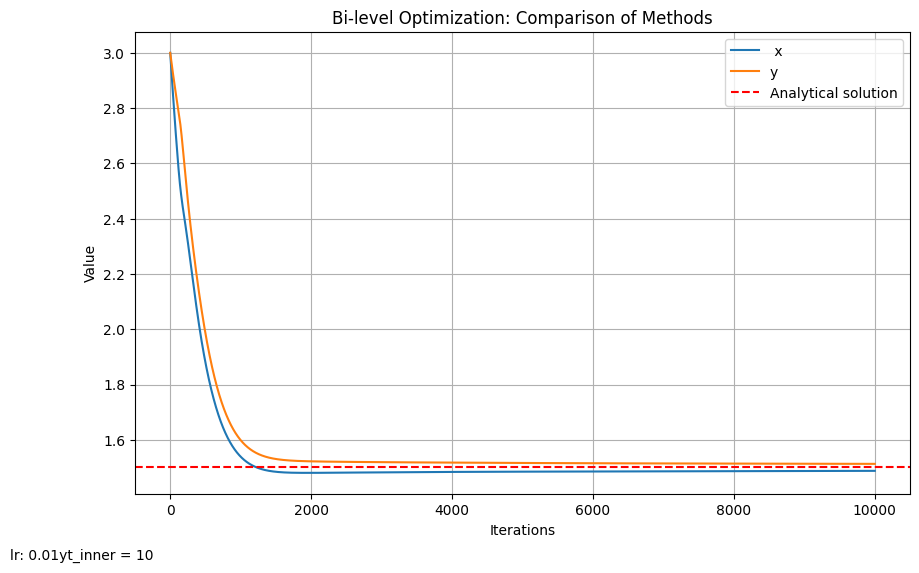

Final results:
Unrolled: x = 1.5000, y = 1.5001
Analytical: x = 1.5000, y = 1.5000


In [397]:
plt.figure(figsize=(10, 6))
plt.plot(x_history, label=' x')
plt.plot(y_history, label='y')
#plt.plot(y_prime_history, label='y_prime')
#plt.plot(λ_history, label='λ')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Bi-level Optimization: Comparison of Methods')
plt.legend()
plt.grid(True)
plt.figtext(0., 0., 'lr: {:.2f}'.format(0.01)+ 'yt_inner = 10')
#plt.savefig('figs/PDGA_yinner=1.png')
plt.show()

print(f"Final results:")
print(f"Unrolled: x = {x_total[-1]:.4f}, y = {y_total[-1]:.4f}")
print(f"Analytical: x = {x_analytical:.4f}, y = {y_analytical:.4f}")

In [534]:
EPS = 0.001

@jax.jit
def F(x, y):
    return (x - 1)**2 + (y - 2)**2

@jax.jit
def g(x, y):
    return (y - x)**2  # Lower-level objective

@jax.jit
def lagrange(x, y, y_prime, λ):
    return F(x, y) + λ * (g(x, y) - g(x, y_prime))

@jax.jit
def h(x, y, y_prime):
    return g(x, y) - g(x, y_prime)




grad_lagrange = jax.jit(grad(lagrange, argnums=(0, 1, 2, 3)))
grad_g = jax.jit(grad(g, argnums=(0, 1)))

def optimize_x(num_iterations, lr, λ=50.0):
    x = 2. # Initial value of x
    y = 2.  # Initial value of y
    y_prime = 1.  # Initial value of y_prime
    h_val = h(x,y,y_prime)
    x_history, y_history, y_prime_history, λ_history, h_history = [x], [y], [y_prime], [λ], [h_val]
    h_history = [h_val]
    
    for i in range(num_iterations):

        grad_y_prime = grad_g(x,y_prime)[1]

        for _ in range(5):
            #grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

                # Update y_prime using gradient ascent
            y_prime += lr * grad_y_prime

                #y_prime -= lr * grad_g(x,y_prime)[1]

        # Update λ using gradient ascent
        grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

        λ += lr * grad_λ


        h_val = h(x, y, y_prime)
        #λ += ((1)*h_val - h_history[-1])
        λ = max(0.0, λ)  # Project λ to be non-negative
        λ = min(max(0.0, λ),100.)  # Project λ to be non-negative

        λ_history.append(λ)
        h_history.append(h_val)
        #grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

      

        # Compute the gradient of the Lagrangian
        #grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)

        # Update x using gradient descent
        x -= lr * grad_x

        # Update y using gradient descent
        y -= lr * grad_y
        #y -= learning_rate_x * grad_y
                
        y_prime_history.append(y_prime)

        grad_norm = jnp.sqrt(grad_x**2 + grad_y**2 + grad_y_prime**2 + grad_λ**2)
        
        # Check KKT conditions
        if grad_norm < EPS and jnp.abs(h_val) < EPS:
            print(f"Converged at iteration {i}")
            break
        y_history.append(y)
        x_history.append(x)




    
    return x_history, y_history, y_prime_history, λ_history


lr = 0.0001
# Run the optimization
x_history, y_history, y_prime_history, λ_history  = optimize_x(num_iterations=10000, lr=lr)
x_history[-1], y_history[-1]  # Optimal x

(Array(9.414327, dtype=float32, weak_type=True),
 Array(6.6417966, dtype=float32, weak_type=True))

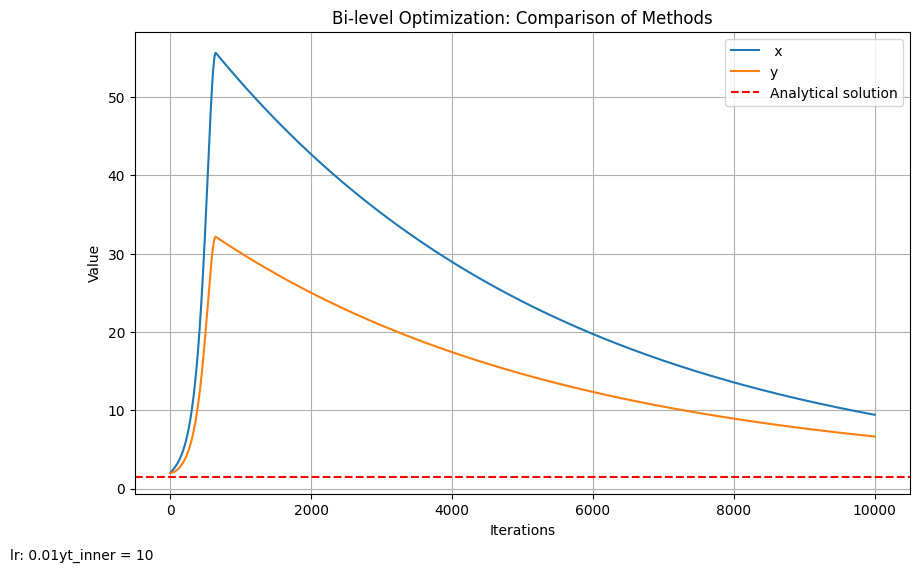

Final results:
Unrolled: x = 1.5000, y = 1.5001
Analytical: x = 1.5000, y = 1.5000


In [535]:
plt.figure(figsize=(10, 6))
plt.plot(x_history, label=' x')
plt.plot(y_history, label='y')
#plt.plot(y_prime_history, label='y_prime')
#plt.plot(λ_history, label='λ')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.title('Bi-level Optimization: Comparison of Methods')
plt.legend()
plt.grid(True)
plt.figtext(0., 0., 'lr: {:.2f}'.format(0.01)+ 'yt_inner = 10')
#plt.savefig('figs/PDGA_yinner=1.png')
plt.show()

print(f"Final results:")
print(f"Unrolled: x = {x_total[-1]:.4f}, y = {y_total[-1]:.4f}")
print(f"Analytical: x = {x_analytical:.4f}, y = {y_analytical:.4f}")

# WIP after this block

In [19]:
import numpy as np

# Define outer and inner level functions
def F(x, y):
    """Outer-level objective."""
    return (x - 1)**2 + (y - 2)**2

def g(x, y):
    """Inner-level objective."""
    return (y - x)**2

# Smoothed version of the inner minimization problem
def g_star(x, alpha, num_iterations=10):
    """Solve the inner problem for a fixed x via gradient descent."""
    y = 0.1
    for _ in range(num_iterations):
        grad_y = 2 * (y - x) + alpha * y  # Gradient of smoothed inner function
        y -= 0.01 * grad_y  # Gradient descent update for y
    return y

# Define the Lagrangian
def Lagrangian(x,y, lambda_, alpha):
    """Lagrangian function combining primal and dual variables."""
    # Constraint function h(z)
    return F(x,y) + lambda_ * h_tilde(x,y)

# Gradient of the Lagrangian w.r.t z (x, y) using autograd
def grad_Lagrangian_wrt_z(x,y, lambda_, alpha):
    """Compute the gradient of the Lagrangian w.r.t z (which includes both x and y)."""
    return grad(Lagrangian, argnums=(0,1))(x,y, lambda_, alpha)

def h_tilde(x,y):
    return g(x, y) - g_star(x, 0.1, num_iterations=20)
    

# Primal-dual optimizer
def primal_dual_bilevel_optimizer(num_iterations, learning_rate, alpha, init_x, init_y):
    """Primal-dual optimization for bilevel problems."""
    x, y = init_x, init_y
    lambda_ = 1.0  # Initial value of the dual variable
    
    x_history = [x]
    y_history = [y]
    lambda_history = [lambda_]


    for t in range(num_iterations):
        # Step 1: Update y (inner variable) using gradient descent (implicit step)
        y_history.append(y)
        
        
        lambda_ = max(0, lambda_ + learning_rate * h_tilde(x,y))  # Ensure non-negative lambda
        lambda_history.append(lambda_)
        
        # Step 3: Update the primal variable z = (x, y) using the gradient of the Lagrangian
        grad_x, grad_y = grad_Lagrangian_wrt_z(x,y, lambda_, alpha)
        x -= learning_rate * grad_x
        y -= learning_rate *grad_y # Update z = (x, y)
        x_history.append(x)
    
    return x_history, y_history, lambda_history

# Running the primal-dual optimizer
x_history, y_history, lambda_history = primal_dual_bilevel_optimizer(
    num_iterations=200, learning_rate=0.01, alpha=0.1, init_x=0.5, init_y=0.5
)

# Final optimized values
print("Final x:", x_history[-1])
print("Final y:", y_history[-1])
print("Final lambda:", lambda_history[-1])


Final x: 1.276858
Final y: 1.7692761
Final lambda: 0.37337103


TypeError: 'numpy.ndarray' object is not callable

## Unrolling gradients

This is a nested algorithm. 

First, in the inner loop calculate df/dy for a given x. 

Then in the outer loop, use all the iterates from the inner to get dF/dy

Then calculate dF/dx as usual. 

We now have an expression for DF = dF/dx + dF/dy*dy/dx

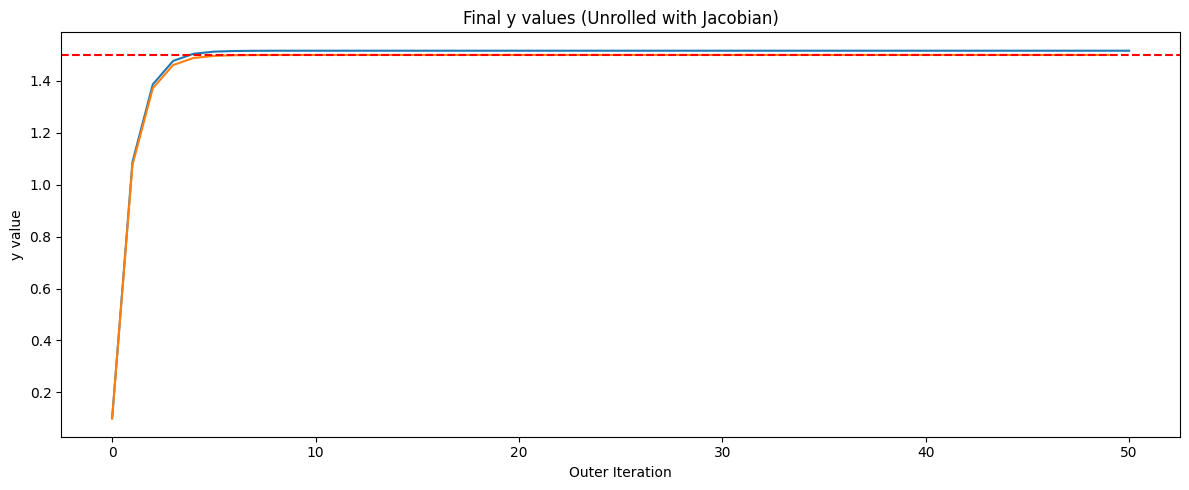

Final x value: 1.516344666481018
Final y value: 1.5000152587890625
Final objective value: 0.5165965557098389


In [12]:
import jax
import jax.numpy as jnp

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (x - y)**2

grad_f_y = jax.grad(f, argnums=1)
grad_F_x = jax.grad(F, argnums=0)
grad_F_y = jax.grad(F, argnums=1)

def unrolled_gradient_with_jacobian(x_init, y_init, inner_lr=0.1, outer_lr=0.01, inner_steps=20, outer_steps=50):
    def inner_loop_single(x, y_init):
        def body_fun(y, _):
            y_next = y - inner_lr * grad_f_y(x, y) #df/dy
            return y_next, y_next
        _, y_history = jax.lax.scan(body_fun, y_init, None, length=inner_steps)
        return jnp.concatenate([jnp.array([y_init]), y_history])

    def total_loss(x, y_history):
        return jnp.sum(jax.vmap(lambda y: F(x, y))(y_history))

    x = x_init
    x_history = [x]
    y_histories = []

    for _ in range(outer_steps):
        # Compute y_history
        y_history = inner_loop_single(x, y_init)
        y_histories.append(y_history)

        # Compute Jacobian of y_history with respect to x
        J_y_x = jax.jacfwd(inner_loop_single, argnums=0)(x, y_init) #dx/dy

        # Compute gradients
        dF_dx = jax.grad(lambda x: total_loss(x, y_history))(x)
        dF_dy = jax.vmap(grad_F_y, in_axes=(None, 0))(x, y_history)

        # Compute total gradient
        #total_grad = dF/dx + ∑_t (dF/dy_t * dy_t/dx)

        total_grad = dF_dx + jnp.sum(dF_dy * J_y_x) #dF/dx + dF/dy * dx/dy

        # Update x
        x = x - outer_lr * total_grad
        x_history.append(x)

    return jnp.array(x_history), jnp.array(y_histories)

# Run optimization
x_unrolled, y_unrolled = unrolled_gradient_with_jacobian(0.1, 0.1)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(x_unrolled)
plt.title('x trajectory (Unrolled with Jacobian)')
plt.xlabel('Iteration')
plt.ylabel('x value')

plt.plot([yh[-1] for yh in y_unrolled])
plt.title('Final y values (Unrolled with Jacobian)')
plt.xlabel('Outer Iteration')
plt.ylabel('y value')
plt.axhline(y=x_analytical, color='r', linestyle='--', label='Analytical solution')

plt.tight_layout()
plt.show()

print(f"Final x value: {x_unrolled[-1]}")
print(f"Final y value: {y_unrolled[-1][-1]}")
print(f"Final objective value: {F(x_unrolled[-1], y_unrolled[-1][-1])}")

## Implicit function theorem

Use IFT to get the total derivative. Note that this doesn't require nesting either

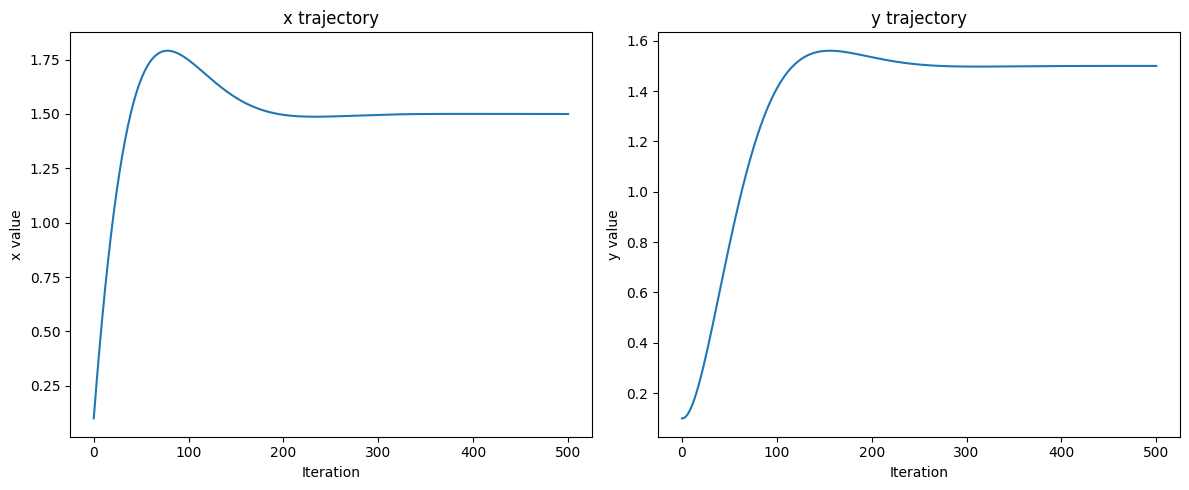

Final x value: 1.5000088214874268
Final y value: 1.5000815391540527
Final objective value: 0.499927282333374


In [13]:
import jax
import jax.numpy as jnp

def F(x, y):
    return (x - 1)**2 + (y - 2)**2

def f(x, y):
    return (x - y)**2

# Gradients
df_dy = jax.grad(f, argnums=1)
dF_dx = jax.grad(F, argnums=0)
dF_dy = jax.grad(F, argnums=1)

# Hessian and cross-derivative
d2f_dy2 = jax.grad(jax.grad(f, argnums=1), argnums=1)
d2f_dxdy = jax.grad(jax.grad(f, argnums=1), argnums=0)

def total_gradient(x_init, y_init, learning_rate=0.01, num_iterations=500):
    x, y = x_init, y_init
    x_history, y_history = [x], [y]
    
    for _ in range(num_iterations):
        # Inner optimization step
        y -= learning_rate * df_dy(x, y)
        y_history.append(y)
        
        # Compute implicit gradient using IFT
        dy_dx = -d2f_dxdy(x, y) / d2f_dy2(x, y)
        implicit_grad = dF_dx(x, y) + dF_dy(x, y) * dy_dx
        
        # Outer optimization step
        x -= learning_rate * implicit_grad
        x_history.append(x)
    
    return jnp.array(x_history), jnp.array(y_history)

# Run optimization
x_total, y_total = total_gradient(0.1, 0.1)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_total)
plt.title('x trajectory')
plt.xlabel('Iteration')
plt.ylabel('x value')

plt.subplot(1, 2, 2)
plt.plot(y_total)
plt.title('y trajectory')
plt.xlabel('Iteration')
plt.ylabel('y value')

plt.tight_layout()
plt.show()

print(f"Final x value: {x_total[-1]}")
print(f"Final y value: {y_total[-1]}")
print(f"Final objective value: {F(x_total[-1], y_total[-1])}")

# Solving a matrix game with IFT
https://www.cs.cmu.edu/~conitzer/stackelbergSYNTHESE.pdf

In [66]:
import jax
import jax.numpy as jnp
from jax import grad, jit, jacfwd
import optax
import matplotlib.pyplot as plt

# Set random seed
key = jax.random.PRNGKey(32)

# Combined payoff matrix
payoffs = jnp.array([
    [[1., 1.], [3., 0.]],
    [[0., 0.], [2., 1.]]
])

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def expected_utility(x, y):
    p1 = sigmoid(x)
    p2 = sigmoid(y)
    probs = jnp.array([[p1*p2, p1*(1-p2)], [(1-p1)*p2, (1-p1)*(1-p2)]])
    u1 = jnp.sum(probs * payoffs[:,:,0])
    u2 = jnp.sum(probs * payoffs[:,:,1])
    return p1, p2, u1, u2

@jit
def stackelberg_gradient(x, y):
    grad_u2_y = grad(lambda y: expected_utility(x, y)[3])(y)
    hessian_u2_y = jacfwd(grad(lambda y: expected_utility(x, y)[3]))(y)
    grad_u2_y_x = jacfwd(lambda x: grad(lambda y: expected_utility(x, y)[3])(y))(x)
    grad_y_star = -grad_u2_y_x / hessian_u2_y
    grad_u1_x = grad(lambda x: expected_utility(x, y)[2])(x)
    grad_u1_y = grad(lambda y: expected_utility(x, y)[2])(y)
    return grad_u1_x + grad_y_star * grad_u1_y

@jit
def update(x, y, opt_state1, opt_state2):
    # Update follower (player 2)
    grad_u2 = grad(lambda y: -expected_utility(x, y)[3])(y)
    updates2, opt_state2 = optimizer2.update(grad_u2, opt_state2)
    y = optax.apply_updates(y, updates2)
    
    # Update leader (player 1)
    grad_stackelberg = stackelberg_gradient(x, y)
    updates1, opt_state1 = optimizer1.update(grad_stackelberg, opt_state1)
    x = optax.apply_updates(x, updates1)
    
    return x, y, opt_state1, opt_state2

def plot_strategies(p1, p2, iterations, seed, follower_lr, leader_lr, reg):
    plt.figure(figsize=(10, 6))
    plt.plot(p1, color='blue', label='row - p(up)')
    plt.plot(p2, color='orange', label='col - p(left)') 
    plt.ylabel('Probability')
    plt.xlabel('Step')
    plt.legend()
    plt.title(f'# of Iterations: {iterations}, Seed: {seed}, Follower lr {follower_lr}, Leader lr {leader_lr})')
    #plt.savefig(f'jax_stackelberg_{iterations}_seed={seed}_flr={follower_lr}_llr={leader_lr}_reg={reg}.png')
    plt.close()

# Hyperparameters
outer_iterations = 200
inner_iterations = 5
follower_lr = 0.05
leader_lr = 0.01
regularization = False
weight_decay = 0.1 if regularization else 0.0

# Initialize strategies
x = jax.random.uniform(key, shape=())
y = jax.random.uniform(key, shape=())

print(f"Player 1 initial strategy (probability of playing Up): {sigmoid(x):.4f}")
print(f"Player 2 initial strategy (probability of playing Left): {sigmoid(y):.4f}")

# Set up optimizers
optimizer1 = optax.adam(learning_rate=leader_lr)
optimizer2 = optax.adam(learning_rate=follower_lr)
opt_state1 = optimizer1.init(x)
opt_state2 = optimizer2.init(y)

p1_strategies = []
p2_strategies = []

for _ in range(outer_iterations):
    grad_u2 = grad(lambda y: -expected_utility(x, y)[3])(y)
    updates2, opt_state2 = optimizer2.update(grad_u2, opt_state2)
    y = optax.apply_updates(y, updates2)
    
    x, y, opt_state1, opt_state2 = update(x, y, opt_state1, opt_state2)
    p_up, p_left, _, _ = expected_utility(x, y)
    p1_strategies.append(p_up)
    p2_strategies.append(p_left)

# Final strategies and utilities
p1_strategy = sigmoid(x)
p2_strategy = sigmoid(y)
_, _, final_u1, final_u2 = expected_utility(x, y)

print(f"Player 1 strategy (probability of playing Up): {p1_strategy:.4f}")
print(f"Player 2 strategy (probability of playing Left): {p2_strategy:.4f}")
print(f"Player 1 expected utility: {final_u1:.4f}")
print(f"Player 2 expected utility: {final_u2:.4f}")

# Compute and print gradients
stackelberg_grad = stackelberg_gradient(x, y)
print(f"Stackelberg gradient for Player 1's strategy: {stackelberg_grad:.4f}")

grad_u2 = grad(lambda y: expected_utility(x, y)[3])(y)
print(f"Gradient for Player 2's strategy: {grad_u2:.4f}")

plot_strategies(p1_strategies, p2_strategies, outer_iterations, 32, follower_lr, leader_lr, regularization)

Player 1 initial strategy (probability of playing Up): 0.6796
Player 2 initial strategy (probability of playing Left): 0.6796
Player 1 strategy (probability of playing Up): 0.5129
Player 2 strategy (probability of playing Left): 0.9934
Player 1 expected utility: 0.5262
Player 2 expected utility: 0.5127
Stackelberg gradient for Player 1's strategy: -0.0086
Gradient for Player 2's strategy: 0.0002


Player 1 initial strategy (probability of playing Up): 0.6796
Player 2 initial strategy (probability of playing Left): 0.6796
Player 1 strategy (probability of playing Up): 0.5720
Player 2 strategy (probability of playing Left): 0.9654
Player 1 expected utility: 0.6412
Player 2 expected utility: 0.5670
Stackelberg gradient for Player 1's strategy: 0.0007
Gradient for Player 2's strategy: 0.0048


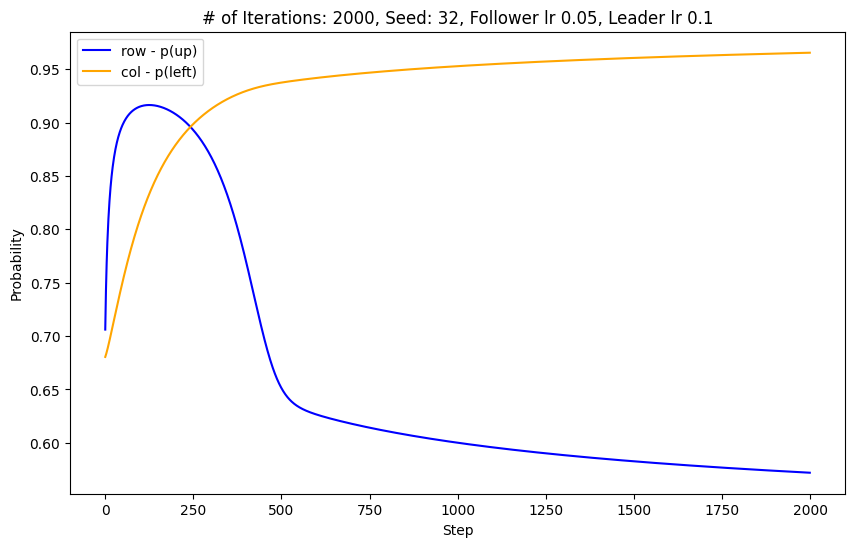

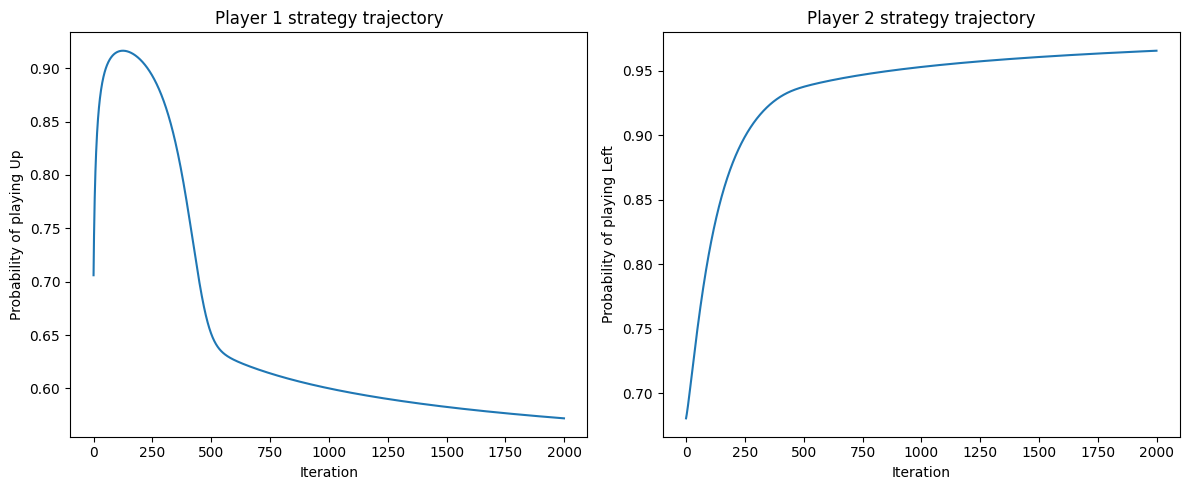

In [67]:
import jax
import jax.numpy as jnp
from jax import grad, jit, jacfwd
import matplotlib.pyplot as plt

# Set random seed
key = jax.random.PRNGKey(32)

# Combined payoff matrix
payoffs = jnp.array([
    [[1., 1.], [3., 0.]],
    [[0., 0.], [2., 1.]]
])

def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

def expected_utility(x, y):
    p1 = sigmoid(x)
    p2 = sigmoid(y)
    probs = jnp.array([[p1*p2, p1*(1-p2)], [(1-p1)*p2, (1-p1)*(1-p2)]])
    u1 = jnp.sum(probs * payoffs[:,:,0])
    u2 = jnp.sum(probs * payoffs[:,:,1])
    return p1, p2, u1, u2

@jit
def stackelberg_gradient(x, y):
    grad_u2_y = grad(lambda y: expected_utility(x, y)[3])(y)
    hessian_u2_y = jacfwd(grad(lambda y: expected_utility(x, y)[3]))(y)
    grad_u2_y_x = jacfwd(lambda x: grad(lambda y: expected_utility(x, y)[3])(y))(x)
    grad_y_star = -grad_u2_y_x / hessian_u2_y
    grad_u1_x = grad(lambda x: expected_utility(x, y)[2])(x)
    grad_u1_y = grad(lambda y: expected_utility(x, y)[2])(y)
    return grad_u1_x + grad_y_star * grad_u1_y

@jit
def update(x, y, learning_rate1, learning_rate2):
    # Update follower (player 2)
    grad_u2 = grad(lambda y: -expected_utility(x, y)[3])(y)
    y = y - learning_rate2 * grad_u2
    
    # Update leader (player 1)
    grad_stackelberg = stackelberg_gradient(x, y)
    x = x - learning_rate1 * grad_stackelberg
    
    return x, y

def plot_strategies(p1, p2, iterations, seed, follower_lr, leader_lr):
    plt.figure(figsize=(10, 6))
    plt.plot(p1, color='blue', label='row - p(up)')
    plt.plot(p2, color='orange', label='col - p(left)') 
    plt.ylabel('Probability')
    plt.xlabel('Step')
    plt.legend()
    plt.title(f'# of Iterations: {iterations}, Seed: {seed}, Follower lr {follower_lr}, Leader lr {leader_lr}')
    plt.show()

# Hyperparameters
iterations = 2000
follower_lr = 0.05
leader_lr = 0.1

# Initialize strategies
x = jax.random.uniform(key, shape=())
y = jax.random.uniform(key, shape=())

print(f"Player 1 initial strategy (probability of playing Up): {sigmoid(x):.4f}")
print(f"Player 2 initial strategy (probability of playing Left): {sigmoid(y):.4f}")

p1_strategies = []
p2_strategies = []

for _ in range(iterations):
    x, y = update(x, y, leader_lr, follower_lr)
    p_up, p_left, _, _ = expected_utility(x, y)
    p1_strategies.append(p_up)
    p2_strategies.append(p_left)

# Final strategies and utilities
p1_strategy = sigmoid(x)
p2_strategy = sigmoid(y)
_, _, final_u1, final_u2 = expected_utility(x, y)

print(f"Player 1 strategy (probability of playing Up): {p1_strategy:.4f}")
print(f"Player 2 strategy (probability of playing Left): {p2_strategy:.4f}")
print(f"Player 1 expected utility: {final_u1:.4f}")
print(f"Player 2 expected utility: {final_u2:.4f}")

# Compute and print gradients
stackelberg_grad = stackelberg_gradient(x, y)
print(f"Stackelberg gradient for Player 1's strategy: {stackelberg_grad:.4f}")

grad_u2 = grad(lambda y: expected_utility(x, y)[3])(y)
print(f"Gradient for Player 2's strategy: {grad_u2:.4f}")

plot_strategies(p1_strategies, p2_strategies, iterations, 32, follower_lr, leader_lr)

# Plot trajectories
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(p1_strategies)
plt.title('Player 1 strategy trajectory')
plt.xlabel('Iteration')
plt.ylabel('Probability of playing Up')

plt.subplot(1, 2, 2)
plt.plot(p2_strategies)
plt.title('Player 2 strategy trajectory')
plt.xlabel('Iteration')
plt.ylabel('Probability of playing Left')

plt.tight_layout()
plt.show()

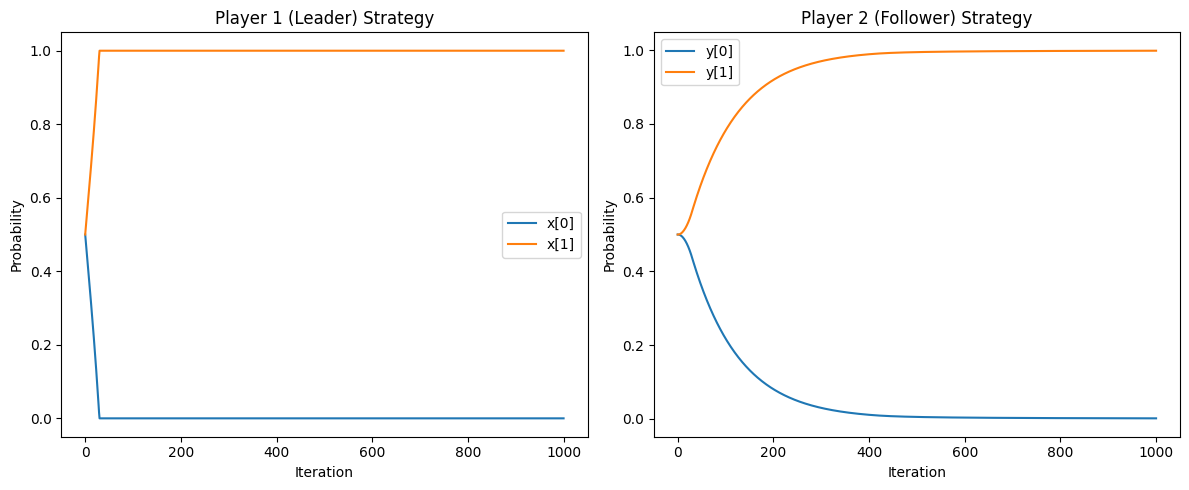

Final strategy for Player 1 (Leader): [0. 1.]
Final strategy for Player 2 (Follower): [0.00144877 0.9985512 ]
Final payoff for Player 1: 1.9971023797988892
Final payoff for Player 2: 0.9985511898994446


In [65]:
import jax
import jax.numpy as jnp
from jax import grad, jit, jacfwd
import matplotlib.pyplot as plt

# Define the payoff matrices
A = jnp.array([[1., 3.], 
               [0., 2.]])

B = jnp.array([[1., 0.], 
               [0., 1.]])

# Define the objective functions
def F(x, y):
    return jnp.dot(jnp.dot(x, A), y)

def f(x, y):
    return jnp.dot(jnp.dot(x, B), y)

# Gradients
dF_dx = jit(grad(F, argnums=0))
dF_dy = jit(grad(F, argnums=1))
df_dy = jit(grad(f, argnums=1))

# Hessian and Jacobian
d2f_dy2 = jit(jacfwd(grad(f, argnums=1)))
d2f_dxdy = jit(jacfwd(grad(f, argnums=1), argnums=0))

@jit
def total_gradient(x, y):
    dy_dx = -d2f_dy2(x, y)/(d2f_dxdy(x, y)+10e-6)
    return dF_dx(x, y) + jnp.dot(dF_dy(x, y), dy_dx)

@jit
def update(x, y, lr_x, lr_y):
    y_new = y + lr_y * df_dy(x, y)
    y_new = jnp.clip(y_new, 0, 1)
    y_new = y_new / jnp.sum(y_new)
    
    x_new = x - lr_x * total_gradient(x, y_new)
    x_new = jnp.clip(x_new, 0, 1)
    x_new = x_new / jnp.sum(x_new)
    
    return x_new, y_new

def optimize(x_init, y_init, lr_x=0.01, lr_y=0.01, num_iterations=1000):
    x, y = x_init, y_init
    x_history, y_history = [x], [y]
    
    for _ in range(num_iterations):
        x, y = update(x, y, lr_x, lr_y)
        x_history.append(x)
        y_history.append(y)
    
    return jnp.array(x_history), jnp.array(y_history)

# Run optimization
x_init = jnp.array([0.5, 0.5])
y_init = jnp.array([0.5, 0.5])
x_history, y_history = optimize(x_init, y_init)

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_history[:, 0], label='x[0]')
plt.plot(x_history[:, 1], label='x[1]')
plt.title('Player 1 (Leader) Strategy')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_history[:, 0], label='y[0]')
plt.plot(y_history[:, 1], label='y[1]')
plt.title('Player 2 (Follower) Strategy')
plt.xlabel('Iteration')
plt.ylabel('Probability')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final strategy for Player 1 (Leader): {x_history[-1]}")
print(f"Final strategy for Player 2 (Follower): {y_history[-1]}")
print(f"Final payoff for Player 1: {F(x_history[-1], y_history[-1])}")
print(f"Final payoff for Player 2: {f(x_history[-1], y_history[-1])}")

In [68]:
for i in range(1):
    print(i)

0


In [70]:
# check the inner loop is getting the latest copy of the LM

#plot the inner computation with and without the regulairzer, gives existence of bi-level optimization 

#plug in the derterministic PG theorem into the mixed derivative. 


#standard the experiments , check the reward model. 
#check derivative of the reward model (should it be a jacobian?)
# use the torchopt IFT
# ask about 2 heads vs one head
# make sure the why the inner doesn't get the latest copy of the LM
# 

In [242]:
import jax
import jax.numpy as jnp
from jax import grad, jit

# Set the tolerance for KKT conditions
EPS = 1e-6

# Define the outer objective function F(x, y)
@jit
def F(x, y):
    """
    Outer objective function:
    f(x, y) = 0.5 * [(1 - y1)^2 + (x - y2)^2]
    """
    return 0.5 * ((1.0 - y[0])**2 + (x - y[1])**2)

# Define the inner objective function g(x, y)
@jit
def g(x, y):
    """
    Inner objective function:
    g(x, y) = 0.5 * y1^2 - x * y1
    """
    return 0.5 * y[0]**2 - x * y[0]

# Define the Lagrangian
@jit
def lagrange(x, y, y_prime, λ):
    """
    Lagrangian function:
    L(x, y, y', λ) = F(x, y) + λ * (g(x, y) - g(x, y'))
    """
    return F(x, y) + λ * (g(x, y) - g(x, y_prime))

# Define the constraint function h(x, y, y_prime)
@jit
def h(x, y, y_prime):
    """
    Constraint:
    h(x, y, y') = g(x, y) - g(x, y')
    Should be zero if y minimizes g(x, y)
    """
    return g(x, y) - g(x, y_prime)

# Compute gradients of the Lagrangian with respect to (x, y, y_prime, λ)
grad_lagrange = jit(grad(lagrange, argnums=(0, 1, 2, 3)))

def optimize_x(num_iterations, lr, λ_init=2.0):
    """
    Optimize x, y, y_prime, and λ to solve the bilevel optimization problem.

    Args:
        num_iterations (int): Maximum number of iterations.
        lr (float): Learning rate.
        λ_init (float): Initial value of the Lagrange multiplier.

    Returns:
        Tuple of histories: (x_history, y_history, y_prime_history, λ_history, h_history)
    """
    # Initialize variables
    x = 2.0  # Initial value of x
    y = jnp.array([0.5, 0.5])  # Initial value of y (y1, y2)
    y_prime = jnp.array([2.0, 2.0])  # Initial value of y_prime (y1', y2')
    λ = λ_init
    h_val = h(x, y, y_prime)
    
    # Histories for analysis (optional)
    x_history = [x]
    y_history = [y]
    y_prime_history = [y_prime]
    λ_history = [λ]
    h_history = [h_val]
    
    for i in range(num_iterations):
        # Compute gradients
        grad_x, grad_y, grad_y_prime, grad_λ = grad_lagrange(x, y, y_prime, λ)
        
        # Update y_prime using gradient ascent
        y_prime += lr * grad_y_prime
        
        # Update λ using gradient ascent
        λ += lr * grad_λ
        λ = jnp.clip(λ, 0.0, 100.0)  # Ensure λ is non-negative
        
        # Update x using gradient descent
        x -= lr * grad_x
        
        # Update y using gradient descent
        y -= lr * grad_y
        
        # Compute current constraint value
        h_val = h(x, y, y_prime)
        
        # Append to histories
        x_history.append(x)
        y_history.append(y)
        y_prime_history.append(y_prime)
        λ_history.append(λ)
        h_history.append(h_val)
        
        # Compute the norm of the gradient vector for stationarity
        # Flatten grad_y and grad_y_prime since they are vectors
        grad_norm = jnp.sqrt(grad_x**2 + jnp.sum(grad_y**2) + jnp.sum(grad_y_prime**2) + grad_λ**2)
        
        # Check KKT conditions
        if grad_norm < EPS and jnp.abs(h_val) < EPS:
            print(f"Converged at iteration {i}")
            break
        
        # Optionally, print progress every 1000 iterations
        if i % 1000 == 0:
            print(f"Iter {i}: x={x:.6f}, y={y}, y_prime={y_prime}, λ={λ:.6f}, h={h_val:.6f}, grad_norm={grad_norm:.6f}")
    
    return x_history, y_history, y_prime_history, λ_history, h_history

# Run the optimization
x_history, y_history, y_prime_history, λ_history, h_history = optimize_x(num_iterations=50, lr=0.2)

# Retrieve the optimal values
optimal_x = x_history[-1]
optimal_y = y_history[-1]
optimal_y_prime = y_prime_history[-1]
optimal_λ = λ_history[-1]
final_h = h_history[-1]

print("\nOptimization Results:")
print(f"Optimal x: {optimal_x}")
print(f"Optimal y: {optimal_y}")
print(f"Optimal y_prime: {optimal_y_prime}")
print(f"Optimal λ: {optimal_λ}")
print(f"Final constraint value h: {final_h}")


Iter 0: x=1.100000, y=[1.2 0.8], y_prime=[2. 2.], λ=2.225000, h=-0.400000, grad_norm=6.001302

Optimization Results:
Optimal x: 0.987421452999115
Optimal y: [0.9904319 0.9803258]
Optimal y_prime: [0.98470813 2.        ]
Optimal λ: 2.032201051712036
Final constraint value h: 8.642673492431641e-07
